#  Enhancing Animal Adoption Through Data Science


In the realm of animal rescue, a powerful image can be a lifeline for countless animals awaiting adoption. This project delves into the art of predicting pet photo appeal to enhance their chances of finding loving homes. By harnessing the power of data science and leveraging both images and metadata, I seek to classify pet photos as 'adoptable' or 'not adoptable.' Through the use of Convolutional Neural Networks (CNNs), I aim to automatically discern visual cues that influence engagement. The goal is to equip shelters with actionable insights, ultimately saving lives one image at a time.

In [2]:
import numpy as np
import pandas as pd
import time,os

# Vizualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Loading Data Sets 

In [3]:
train_df = '../input/petfinder-pawpularity-score/train.csv'
test_df = '../input/petfinder-pawpularity-score/test.csv'

train_data = pd.read_csv(train_df)
test_data = pd.read_csv(test_df)

print('Train Data shape:', train_data.shape)
print('Test Data shape:', test_data.shape)

Train Data shape: (9912, 14)
Test Data shape: (8, 13)


In [4]:
from glob import glob

# Getting the image data (the .jpg data) 
train_jpg = glob('../input/petfinder-pawpularity-score/train/*.jpg')
test_jpg = glob('../input/petfinder-pawpularity-score/test/*.jpg')

## Exploratory Data Analysis and Data Preprocessing

In [5]:
print('Train Data Columns:', train_data.columns)
print('Test Data Columns:', test_data.columns)


Train Data Columns: Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur',
       'Pawpularity'],
      dtype='object')
Test Data Columns: Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')


In [6]:
train_data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [7]:
print('Train Data Missing values:', train_data.info())
print('Test Data Missing values:', test_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB
Train Data Missing values: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         N

There are non-null values in both data sets.

In [8]:
train_data.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [9]:
test_data.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
count,8.000000,8.00000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000
mean,0.625000,0.25000,0.625000,0.25000,0.375000,0.625000,0.500000,0.625000,0.25000,0.500000,0.625000,0.500000
std,0.517549,0.46291,0.517549,0.46291,0.517549,0.517549,0.534522,0.517549,0.46291,0.534522,0.517549,0.534522
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,0.00000,1.000000,0.00000,0.000000,1.000000,0.500000,1.000000,0.00000,0.500000,1.000000,0.500000
75%,1.000000,0.25000,1.000000,0.25000,1.000000,1.000000,1.000000,1.000000,0.25000,1.000000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### Vizualisaction

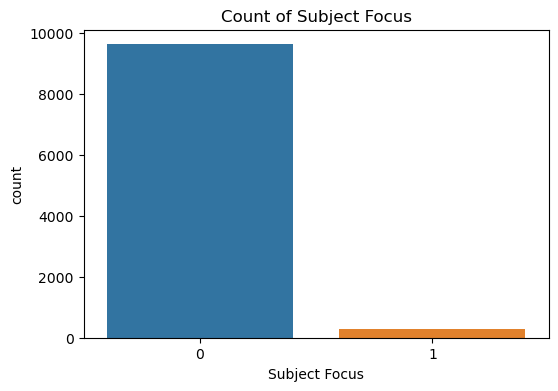

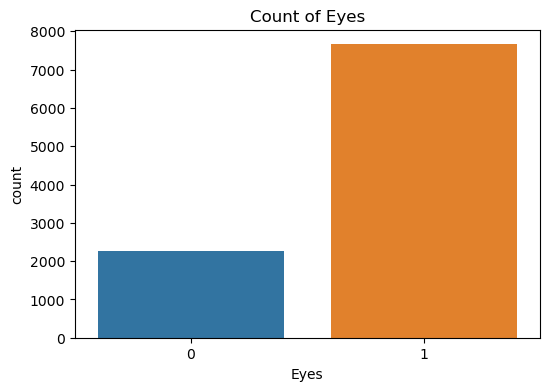

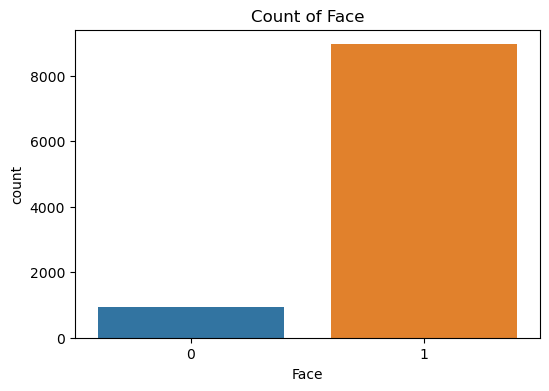

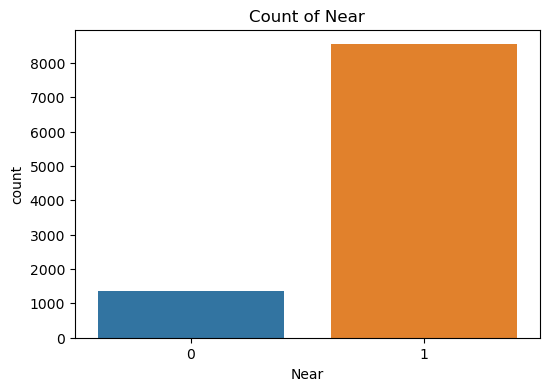

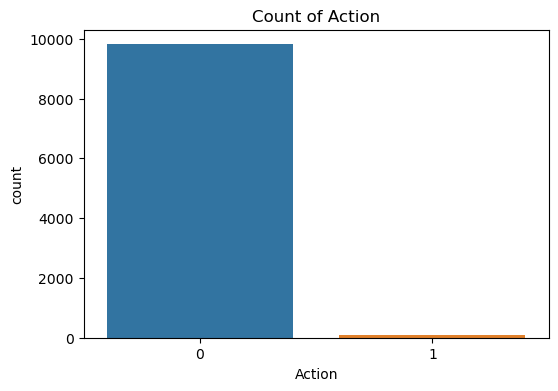

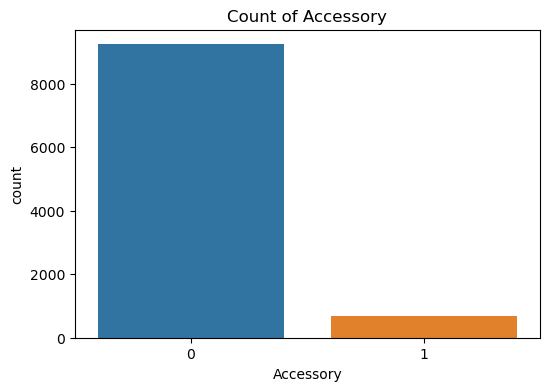

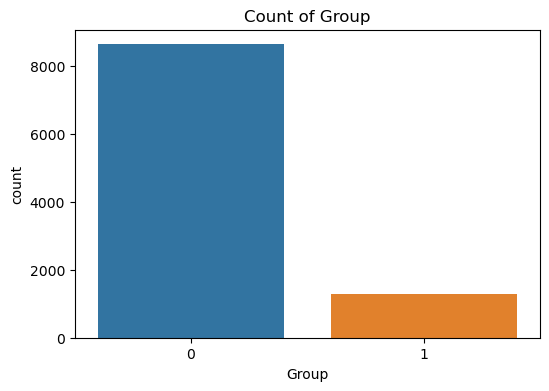

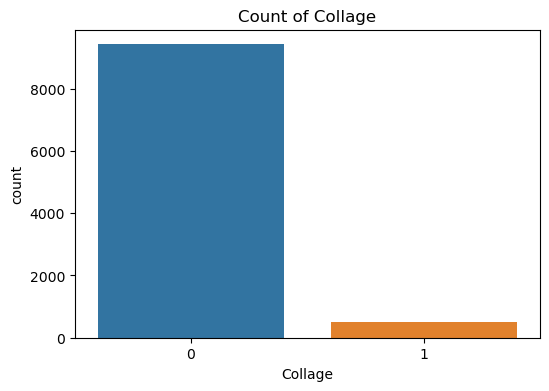

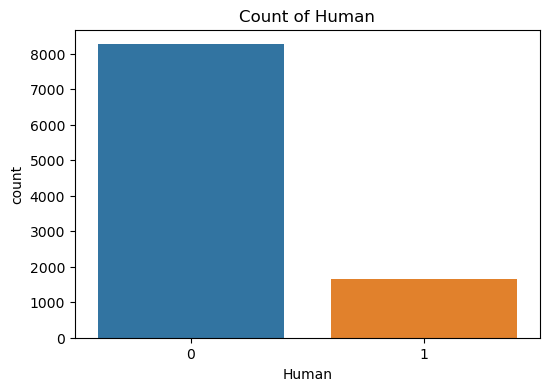

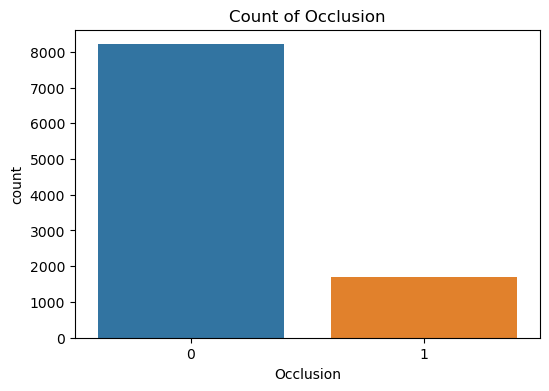

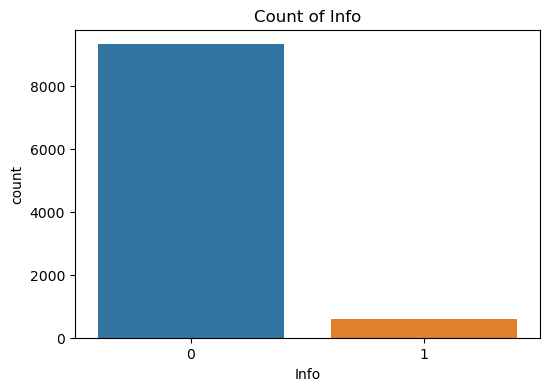

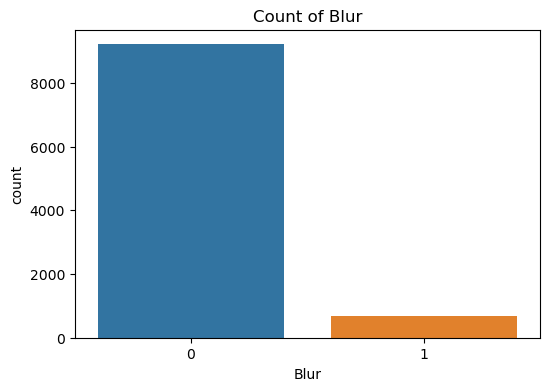

In [10]:
for column in train_data.columns[1:13]: 
    plt.figure(figsize = (6, 4))
    
    sns.countplot(x = column, 
                  data = train_data
                 )
    
    plt.title(f'Count of {column}')
    
    plt.show()


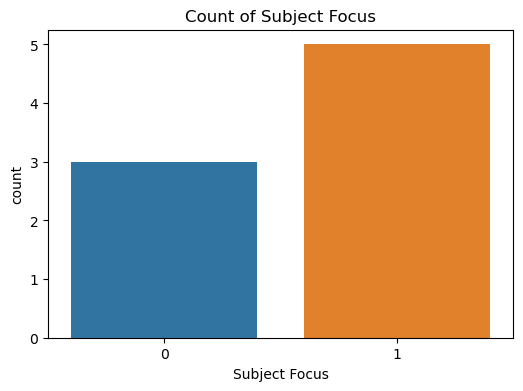

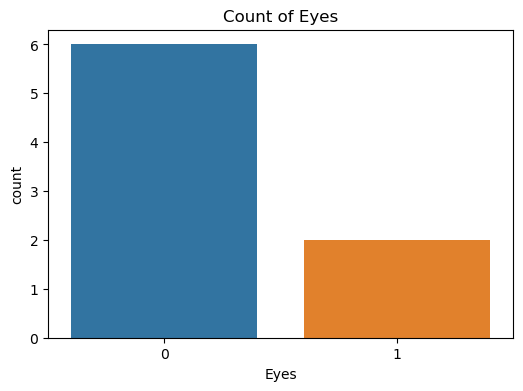

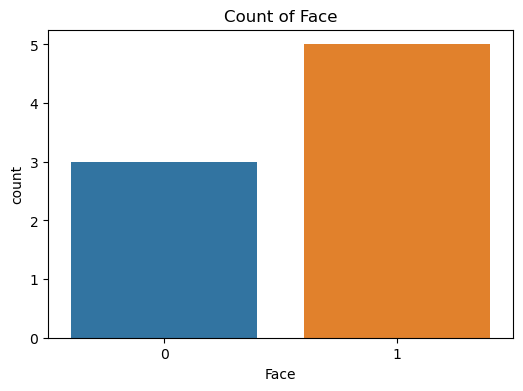

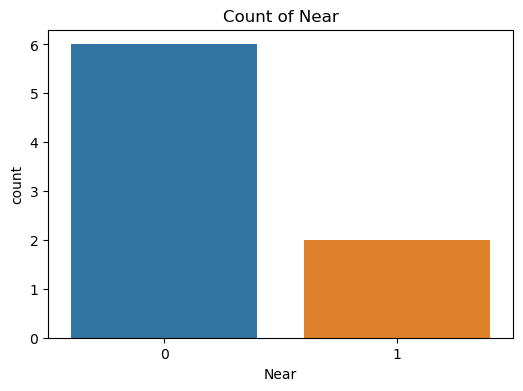

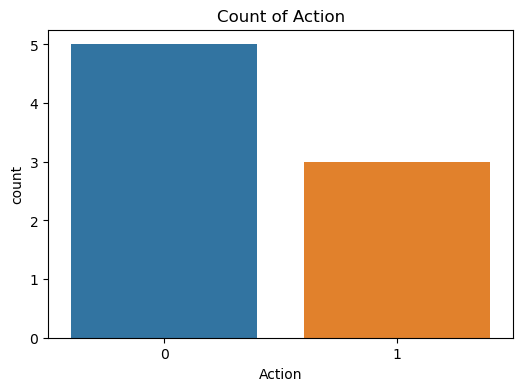

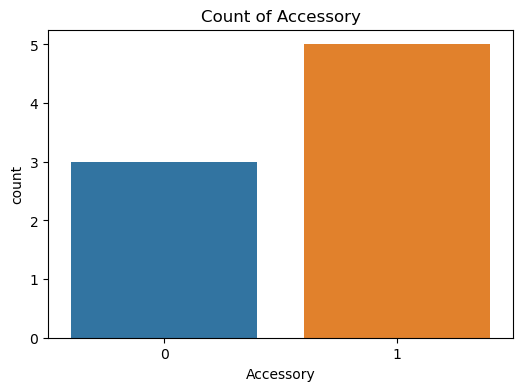

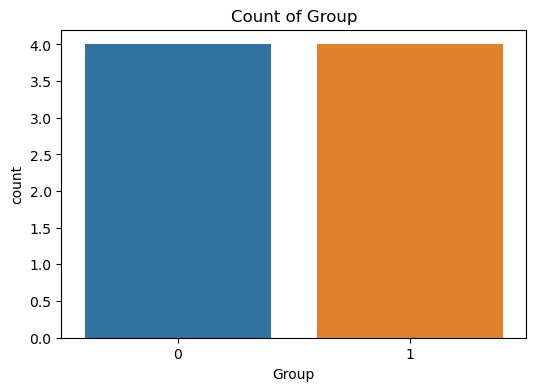

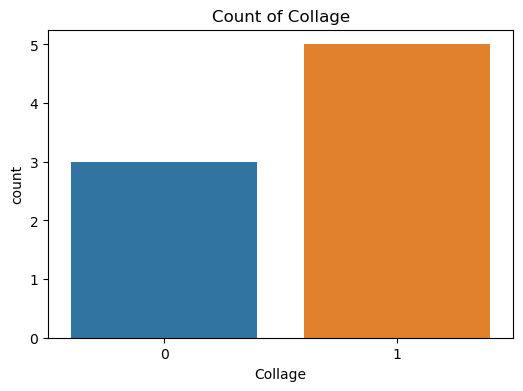

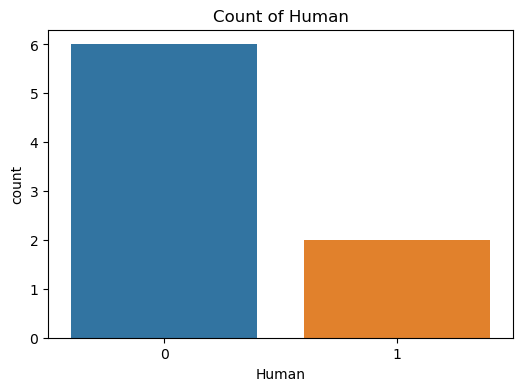

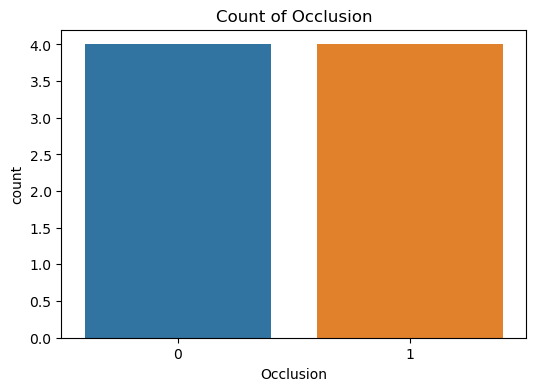

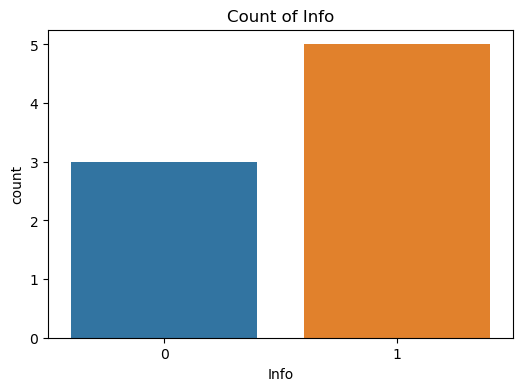

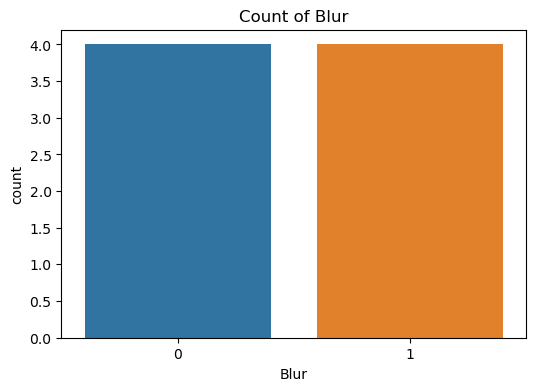

In [11]:
for column in test_data.columns[1:13]: 
    plt.figure(figsize = (6, 4))
    
    sns.countplot(x = column, 
                  data = test_data
                 )
    
    plt.title(f'Count of {column}')
    
    plt.show()


### Distribution of the Target Variable: *Pawpularity*

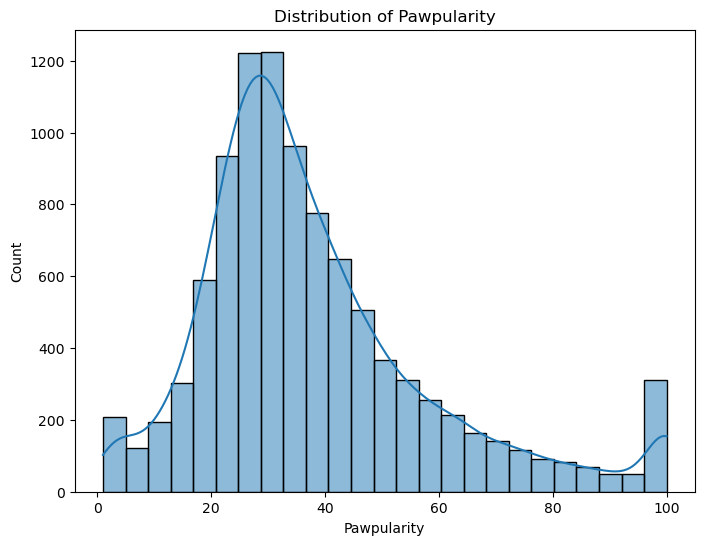

In [12]:
plt.figure(figsize = (8, 6))

sns.histplot(train_data['Pawpularity'], 
             bins = 25, 
             kde = True
            )

plt.title('Distribution of Pawpularity')

plt.show()


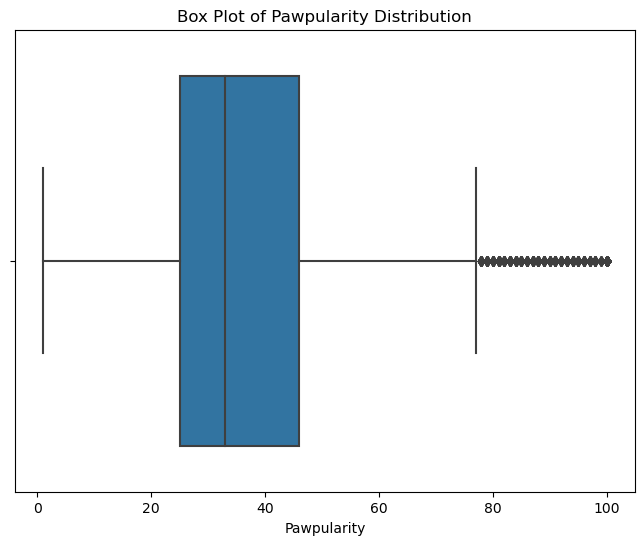

In [13]:
plt.figure(figsize = (8, 6))

sns.boxplot(x = train_data['Pawpularity'])

plt.title('Box Plot of Pawpularity Distribution')
plt.xlabel('Pawpularity')
plt.show()

In [14]:
train_data['Pawpularity'].describe()

count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

In [15]:
# Calculating the amount of outliers in Pawpularity
Q1 = 25
Q3 = 46
IQR = Q3 - Q1

# Lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers below and above the bounds
lower_outliers = train_data[train_data['Pawpularity'] < lower_bound].shape[0]
upper_outliers = train_data[train_data['Pawpularity'] > upper_bound].shape[0]

print("Number of Lower Outliers:", lower_outliers)
print("Number of Upper Outliers:", upper_outliers)


Number of Lower Outliers: 0
Number of Upper Outliers: 624


Once all variables are in the range of 0 to 1, it becomes more accurate to adjust Pawpularity to the same scale. Since Pawpularity represents a percentage, it can be transformed into values between 0 and 1, maintaining its context. Therefore, I divided the target by 100.

In [16]:
train_data['Pawpularity'] /= 100
train_data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,0.42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,0.28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,0.15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,0.72


### Correlaction between Variables

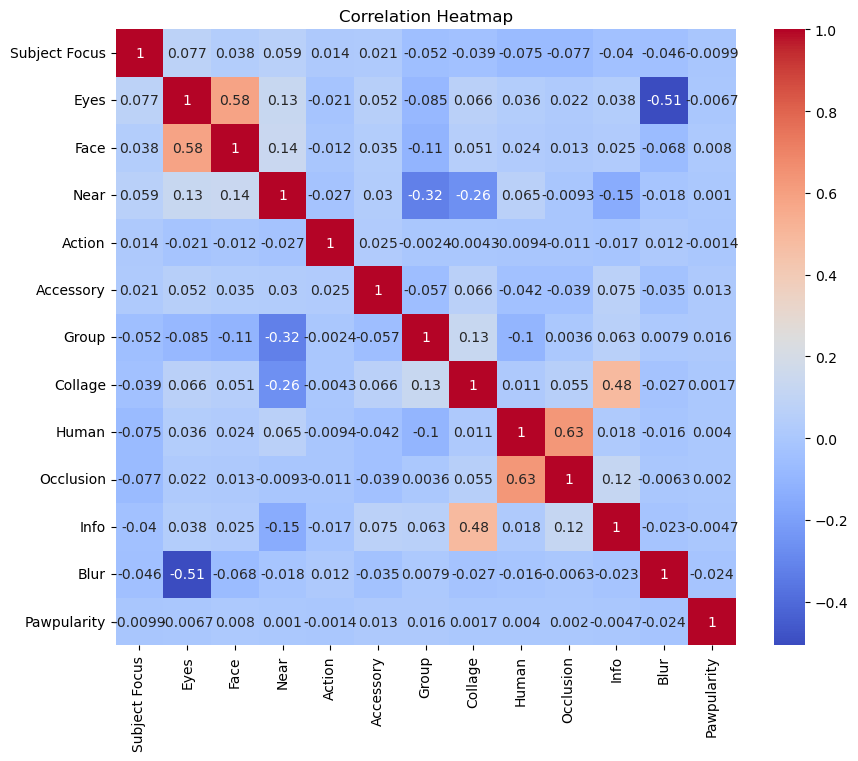

In [17]:
plt.figure(figsize = (10, 8))

sns.heatmap(train_data.iloc[:, 1:14].corr(), 
            annot = True, 
            cmap = 'coolwarm'
           )

plt.title('Correlation Heatmap')

plt.show()


There is not enough correlaction between variables in the data set, specially on the target variable.  

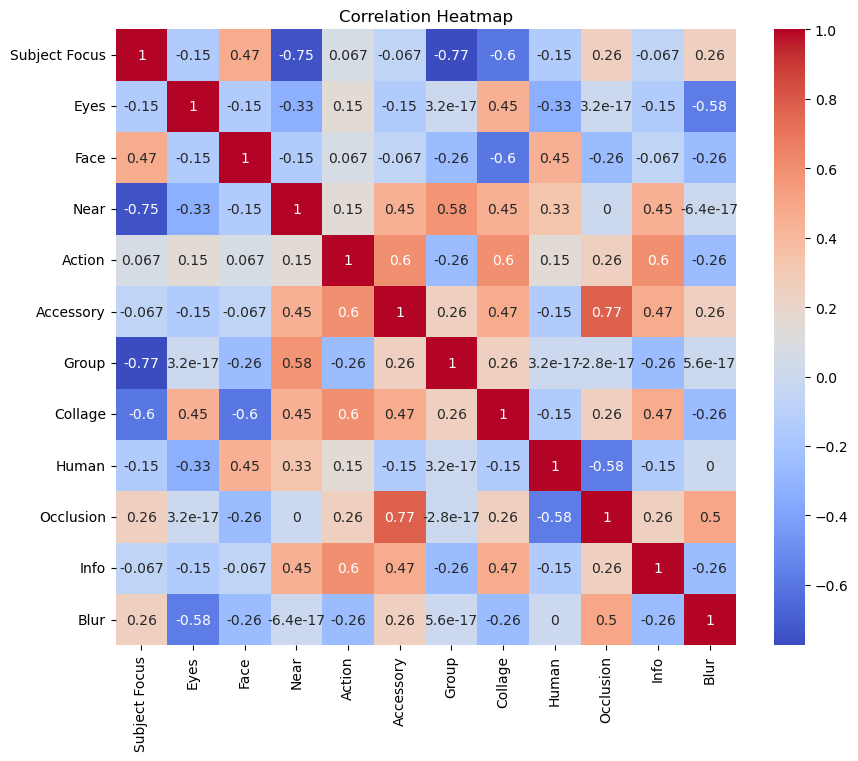

In [18]:
plt.figure(figsize = (10, 8))

sns.heatmap(test_data.iloc[:, 1:13].corr(), 
            annot = True, 
            cmap = 'coolwarm'
           )

plt.title('Correlation Heatmap')

plt.show()


For the test data set, it seems to be more correlaction between the different variables. 

### Comparison of Subject Focus between Train and Test Data

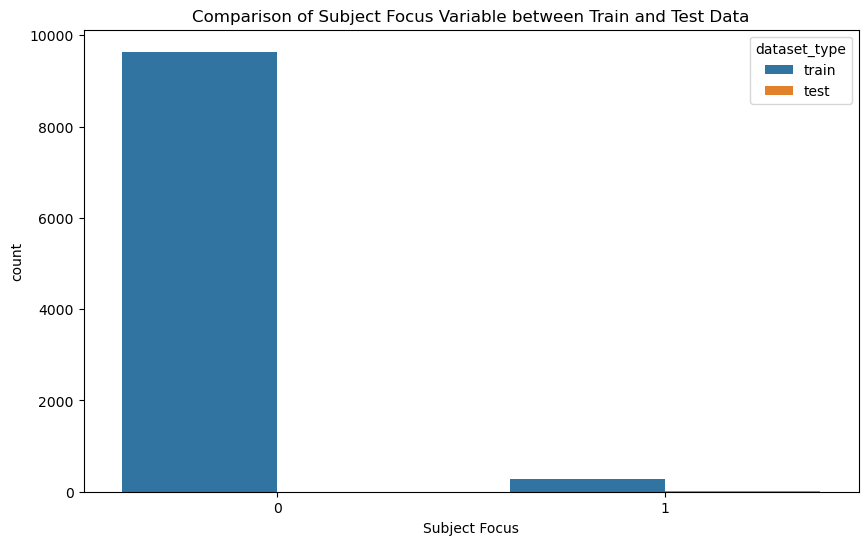

In [19]:
plt.figure(figsize=(10, 6))

combined_data = pd.concat([train_data.assign(dataset_type = 'train'), 
                           test_data.assign(dataset_type = 'test')]
                         )

sns.countplot(x = 'Subject Focus', 
              hue ='dataset_type', 
              data = combined_data,
              order = combined_data['Subject Focus'].value_counts().index,
             )

plt.title('Comparison of Subject Focus Variable between Train and Test Data')

plt.show()




### Satistical Analysis

In [20]:
for column in train_data.columns[1:13]:  
    print(f"{column}: Mean - {train_data[column].mean():.2f}, Std Dev - {train_data[column].std():.2f}")


Subject Focus: Mean - 0.03, Std Dev - 0.16
Eyes: Mean - 0.77, Std Dev - 0.42
Face: Mean - 0.90, Std Dev - 0.29
Near: Mean - 0.86, Std Dev - 0.35
Action: Mean - 0.01, Std Dev - 0.10
Accessory: Mean - 0.07, Std Dev - 0.25
Group: Mean - 0.13, Std Dev - 0.34
Collage: Mean - 0.05, Std Dev - 0.22
Human: Mean - 0.17, Std Dev - 0.37
Occlusion: Mean - 0.17, Std Dev - 0.38
Info: Mean - 0.06, Std Dev - 0.24
Blur: Mean - 0.07, Std Dev - 0.26


#### Interpretation

*Subject Focus*: Mean - 0.03, Std Dev - 0.16

Most values are 0, with a relatively low standard deviation. This suggests that the vast majority of examples have low or absent Subject Focus.


*Eyes*: Mean - 0.77, Std Dev - 0.42

Most values are 1, indicating that the majority of images have visible eyes. The relatively high standard deviation suggests a considerable variety in values.


*Face*: Mean - 0.90, Std Dev - 0.29

The mean is almost 1 suggesting that the vast majority of images have a visible face. The moderate standard deviation indicates some variability in values.


*Near*: Mean - 0.86, Std Dev - 0.35

The high mean suggests that many images are taken from a close distance. The moderate standard deviation suggests some variability in distances.

*Action*: Mean - 0.01, Std Dev - 0.10

The mean close to 0 indicates that most images do not exhibit clear action. The low standard deviation suggests little variation in this attribute.

*Accessory*: Mean - 0.07, Std Dev - 0.25

The mean suggests that most images have no accessories. The moderate standard deviation suggests some variability.


*Group*: Mean - 0.13, Std Dev - 0.34

The mean suggests that some images might have a group of subjects, but it's not very common. The relatively high standard deviation indicates a fair amount of variability in the presence of groups


*Collage*: Mean - 0.05, Std Dev - 0.22

The low mean suggests that collages are not very common in the images. The standard deviation indicates some variability in this attribute.


*Human*: Mean - 0.17, Std Dev - 0.37

The mean suggests that some images have group of subjects, but it's not very common. The relatively high standard deviation indicates a fair amount of variability in the presence of groups.


*Occlusion*: Mean - 0.17, Std Dev - 0.38

The mean indicates that occlusion (partial blocking) of the subject is somewhat common. The standard deviation suggests variability in the degree of occlusion.


*Info*: Mean - 0.06, Std Dev - 0.24

The low mean suggests that images with information or text are not very common. The standard deviation indicates some variability.


*Blur*: Mean - 0.07, Std Dev - 0.26

The mean suggests that some level of blurriness might be present in the images, but it's not very common. The standard deviation indicates some variability.


### Let's take a look into the data sets

In [21]:
print('Number of images in Training Set:', len(train_jpg))
print('Number of images in Testing Set:', len(test_jpg))


Number of images in Training Set: 9912
Number of images in Testing Set: 8


(960, 720, 3)


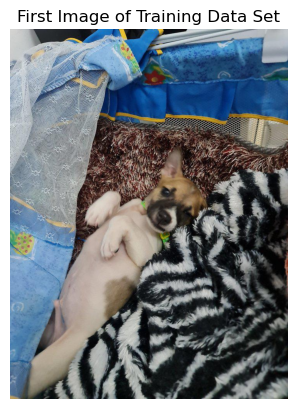

In [22]:
# Lets take a look to the first image of the training data set 
first_image_path = train_jpg[0]
first_image_array = plt.imread(first_image_path) 

print(first_image_array.shape)

plt.imshow(first_image_array)
plt.title('First Image of Training Data Set') 
plt.axis('off')
plt.show()

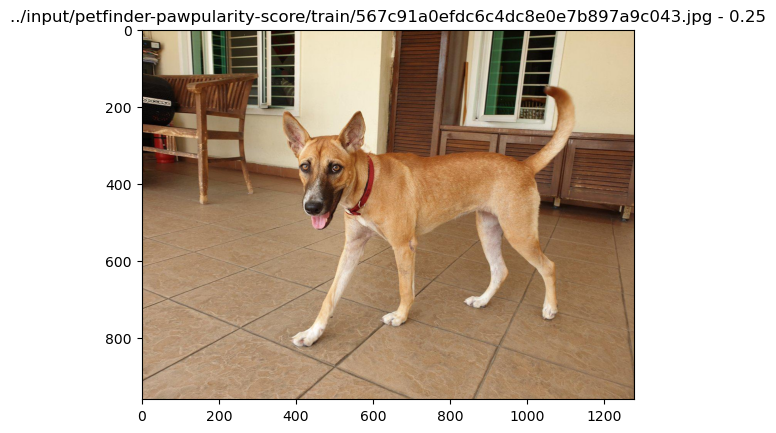

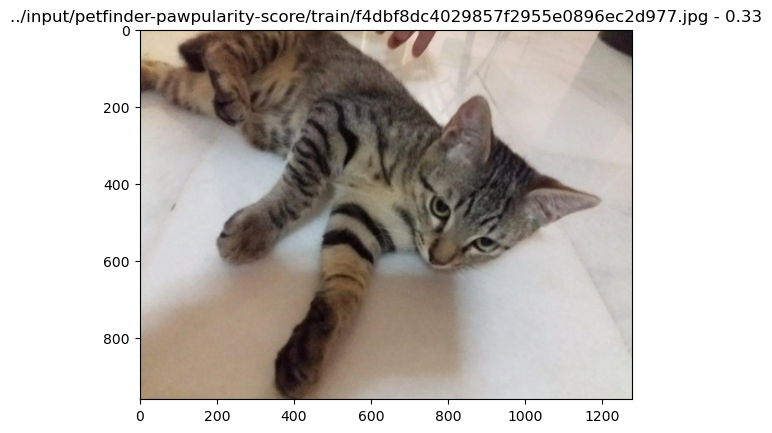

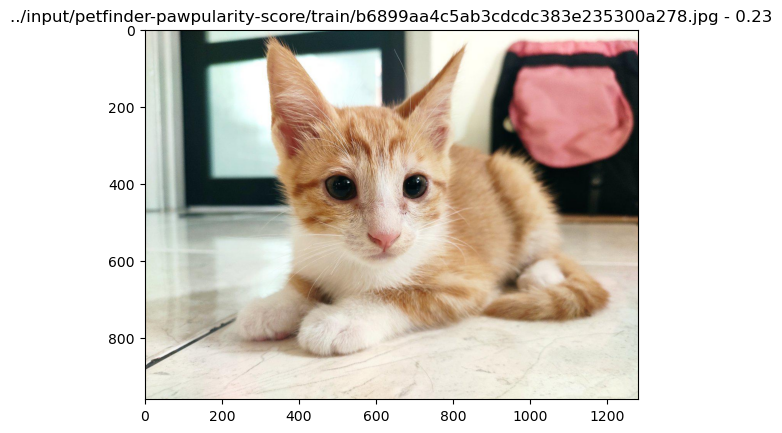

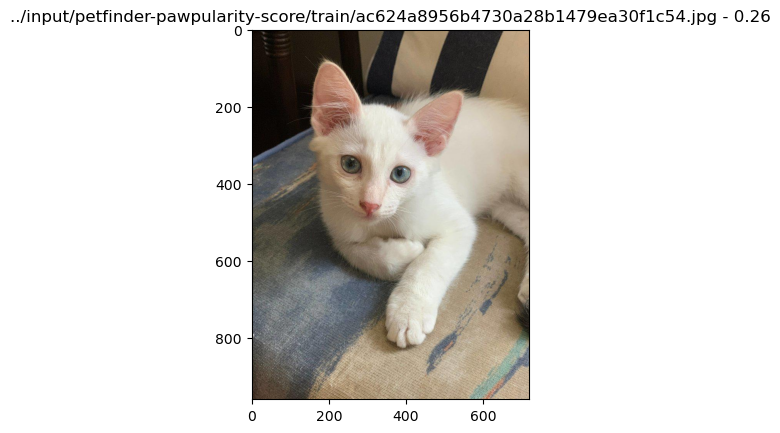

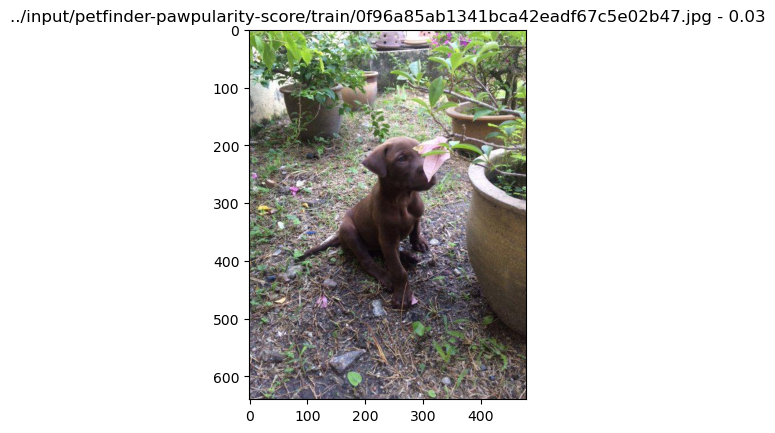

In [23]:
# For each selected image, lets add its ID and Pawpularity value
for i in range(100, 105): 
    id_modified = train_jpg[i].split('/')[-1].split('.')[0]  
    train_pic = train_data[train_data['Id'] == id_modified]  
    pawpularity = train_pic['Pawpularity'].iloc[0]  
    image = plt.imread(train_jpg[i]) 
    
    plt.imshow(image) 
    plt.title(f"{train_jpg[i]} - {pawpularity}")
    plt.show()  


In [24]:
# Setting the size image
image_height = 128
image_width = 128

# Function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [25]:
train_jpg[0]

'../input/petfinder-pawpularity-score/train/7954ebb5c90d9618e34959df0ad5f062.jpg'

type:  <class 'tensorflow.python.framework.ops.EagerTensor'> 
 shape:  (128, 128, 3)


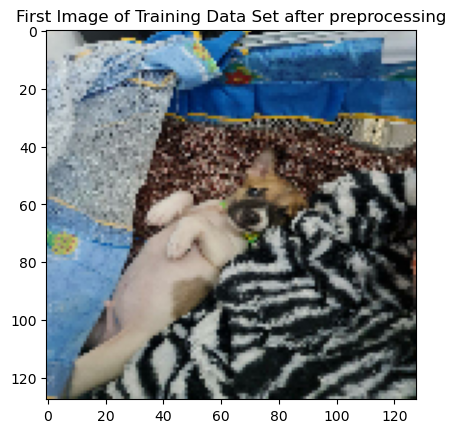

In [26]:
#run the function to show the pre-processing on the first training image only
example_image = path_to_eagertensor('../input/petfinder-pawpularity-score/train/7954ebb5c90d9618e34959df0ad5f062.jpg')

print('type: ', type(example_image),'\n shape: ',example_image.shape)

plt.imshow(example_image)
plt.title('First Image of Training Data Set after preprocessing') 
plt.show()

In [27]:
# All images in the Training Set and put their tensors in a list
X = []
for img in train_jpg:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))

X = np.array(X)

print(type(X),X.shape)

<class 'list'> 9912
<class 'numpy.ndarray'> (9912, 128, 128, 3)


In [28]:
y = train_data['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [29]:
# All the images in the Testing Set and put their tensors in a list
X_sub_list = []
for img in test_jpg:
    new_img_tensor = path_to_eagertensor(img)
    X_sub_list.append(new_img_tensor)
    
print(type(X_sub_list),len(X_sub_list))

X_sub_list = np.array(X_sub_list)

print(type(X_sub_list),X_sub_list.shape)

<class 'list'> 8
<class 'numpy.ndarray'> (8, 128, 128, 3)


Now, I have two NumPy arrays: one for training the model (X) and another for making predictions (X_sub_list).

## Modeling: CNN

Convolutional Neural Networks (CNNs) are a specialized type of deep learning neural network designed for processing structured grid-like data, such as images, videos, and audio. CNNs have proven to be highly effective in tasks related to computer vision, including image classification.

CNNs are chosen for this problem due to their ability to automatically extract meaningful features from images, making them a powerful tool for image-based regression tasks like predicting the Pawpularity scores. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 24
                                                   )


In [31]:
print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape y_train:', y_train.shape) 
print('Shape y_test:', y_test.shape)


Shape X_train: (7929, 128, 128, 3)
Shape X_test: (1983, 128, 128, 3)
Shape y_train: (7929,)
Shape y_test: (1983,)


In [32]:
tf.config.get_visible_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

#### Data Augmentation


Data augmentation enhances a training dataset by applying transformations like rotation, flipping, zooming, and shifting to simulate real-world variations. This boosts model generalization and robustness by introducing diverse examples. The augmented dataset prevents overfitting and better handles various scenarios, improving performance on new data.

In [33]:

datagen = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.2,  
    height_shift_range = 0.2,  
    shear_range = 0.2,  
    zoom_range = 0.2,  
    horizontal_flip = True,  
    vertical_flip = True,  
    fill_mode = 'nearest'
)

augmented_images = datagen.flow(X_train, y_train, batch_size = 32)


#### Model Architecture and Compilation

In [34]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.2)),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.2)),

    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.2)),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout((0.2)),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout((0.2)),
    layers.Dense(2, activation = 'sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [35]:
model.compile(optimizer = 'Adam',
              loss = 'mse',
              metrics = ['mae','mape', RootMeanSquaredError()]
             )

#### Fitting the Model


RMSE assesses how close the model's predictions are to the actual values, while MAE defines the average absolute error of these predictions, and MAPE reveals the percentage error relative to the real values.

With this in mind, I aim for the model to make predictions as accurately as possible. Therefore, I choose RMSE as the metric for implementing early stopping in the model. This implies that if there is no reduction in this value after 8 epochs, the training of the CNN will be halted.

In [36]:
early_stopping = EarlyStopping(monitor = 'val_root_mean_squared_error', 
                               patience = 8, 
                               restore_best_weights = True)

history = model.fit(augmented_images,
                    epochs = 60,
                    batch_size = 32,
                    validation_data = (X_test, y_test),
                    callbacks = [early_stopping]
                   )


Epoch 1/60


2023-08-22 08:48:55.005043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


248/248 [==============================] - 46s 139ms/step - loss: 0.0448 - mae: 0.1614 - mape: 83.4140 - root_mean_squared_error: 0.2116 - val_loss: 0.0423 - val_mae: 0.1616 - val_mape: 86.2898 - val_root_mean_squared_error: 0.2058
Epoch 2/60
248/248 [==============================] - 33s 133ms/step - loss: 0.0431 - mae: 0.1562 - mape: 80.4316 - root_mean_squared_error: 0.2076 - val_loss: 0.0417 - val_mae: 0.1555 - val_mape: 79.8029 - val_root_mean_squared_error: 0.2041
Epoch 3/60
248/248 [==============================] - 33s 131ms/step - loss: 0.0428 - mae: 0.1555 - mape: 79.5550 - root_mean_squared_error: 0.2068 - val_loss: 0.0419 - val_mae: 0.1524 - val_mape: 75.4924 - val_root_mean_squared_error: 0.2046
Epoch 4/60
248/248 [==============================] - 33s 135ms/step - loss: 0.0431 - mae: 0.1560 - mape: 80.2693 - root_mean_squared_error: 0.2075 - val_loss: 0.0420 - val_mae: 0.1518 - val_mape: 74.3375 - val_root_mean_squared_error: 0.2050
Epoch 5/60
248/248 [===================

In [37]:
loss, mae, mape, rmse = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MAPE:", mape)
print("Test RMSE:", rmse)


62/62 [==============================] - 1s 8ms/step - loss: 0.0416 - mae: 0.1552 - mape: 79.3869 - root_mean_squared_error: 0.2041
Test Loss: 0.041647374629974365
Test MAE: 0.15522156655788422
Test MAPE: 79.38687133789062
Test RMSE: 0.204076886177063


#### Evaluation of the CNN

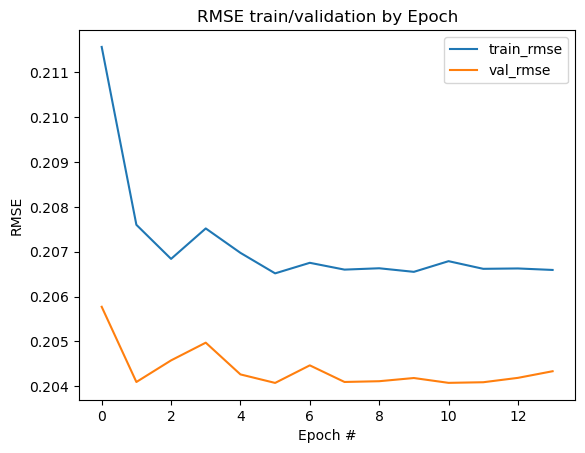

In [38]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'], label='train_rmse')
plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')

plt.title('RMSE train/validation by Epoch')
plt.xlabel('Epoch #')
plt.ylabel('RMSE')
plt.legend(loc='upper right')


#### Using the CNN in unseen Data (test_jpg)

In [39]:
#predict on the submission data
cnn_preds = model.predict(X_sub_list)

print('Shape:', X_sub_list.shape, 'Type:', type(X_sub_list))

print('Shape:', cnn_preds.shape, 'Type:', type(cnn_preds))

1/1 [==============================] - 0s 220ms/step
Shape: (8, 128, 128, 3) Type: <class 'numpy.ndarray'>
Shape: (8, 2) Type: <class 'numpy.ndarray'>


In [40]:
cnn_preds

array([[0.38450316, 0.38447168],
       [0.3844931 , 0.38454837],
       [0.38447216, 0.3845098 ],
       [0.3844884 , 0.3845503 ],
       [0.38452816, 0.38449916],
       [0.3845518 , 0.38455582],
       [0.38457128, 0.38453782],
       [0.38456267, 0.38458923]], dtype=float32)

In [43]:
# Multiply the predicted Pawpularity scores by 100
cnn_preds_scaled = cnn_preds[:, 1] * 100

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ID': test_data['Id'],
    'Pawpularity': cnn_preds_scaled
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)


In [45]:
submission_df.head()

,ID,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,38.447170
1,43a2262d7738e3d420d453815151079e,38.454838
2,4e429cead1848a298432a0acad014c9d,38.450981
3,80bc3ccafcc51b66303c2c263aa38486,38.455029
4,8f49844c382931444e68dffbe20228f4,38.449917
